# High Value Customers Identification

## 0. Importação de Bibliotecas e *Helper Functions*

In [65]:
import warnings
import numpy   as np
import pandas  as pd
import seaborn as sns
from matplotlib          import pyplot as plt
from sklearn.cluster     import KMeans
from yellowbrick.cluster import KElbowVisualizer

In [27]:
def personal_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['font.size'] = 20
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.float_format', lambda x:'%.2f' % x)
    sns.set()
    sns.set(rc = {'figure.figsize':(12,6)})
    warnings.filterwarnings('ignore')

personal_settings()

## 1. Carregando os Dados

In [28]:
df_raw = pd.read_csv('../data/raw/Ecommerce.csv', encoding='unicode_escape')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom,NaN


In [29]:
df_raw = df_raw.drop(columns='Unnamed: 8')
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom


## 2. Descrição dos Dados

In [30]:
df1 = df_raw.copy()

### 2.1 Colunas

In [36]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

### 2.2 Dicionário de Colunas

|     Coluna    |              Significado              |
| ------------- | ------------------------------------- |
|   InvoiceNo   | identificar único de cada transação   |
|   StockCode   | código do item                        |
|   Description | nome do item                          |
|   Quantity    | quantidade de cada item por transação |
|   InvoiceDate | data da transação                     |
|   UnitPrice   | preço do item por unidade             |
|   CustomerID  | identificador único do cliente        |
|   Country     | país em que o cliente reside          |

### 2.3 Dimensões

In [37]:
print(f'Número de linhas/registros: {df1.shape[0]}')
print(f'Número de colunas/atributos: {df1.shape[1]}')

Número de linhas/registros: 541909
Número de colunas/atributos: 8


### 2.4 Tipos de Dados

In [38]:
df1.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

### 2.5 Registros Duplicados

In [39]:
df1.duplicated().sum()

5269

### 2.6 Valores Nulos

In [40]:
df1.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### 2.7 Removendo Valores Nulos

In [41]:
df1 = df1.dropna(subset=['Description', 'CustomerID'])
print('Porcentagem de dados removidos: {:.2f}%'.format((1-(df1.shape[0] / df_raw.shape[0])) * 100))
print(f'Número de registros restantes: {df1.shape[0]}')

Porcentagem de dados removidos: 24.93%
Número de registros restantes: 406829


In [42]:
df1.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

### 2.8 Alterando Tipos de Dados

#### 2.8.1 *InvoiceDate*

In [43]:
df1['InvoiceDate'] = pd.to_datetime(df1['InvoiceDate'], format='%d-%b-%y')
df1['InvoiceDate'].head()

0   2016-11-29
1   2016-11-29
2   2016-11-29
3   2016-11-29
4   2016-11-29
Name: InvoiceDate, dtype: datetime64[ns]

#### 2.8.2 *CustomerID*

In [44]:
df1['CustomerID'] = df1['CustomerID'].astype('int64')
df1['CustomerID'].head()

0    17850
1    17850
2    17850
3    17850
4    17850
Name: CustomerID, dtype: int64

### 2.9 Análise Estatística Descritiva

## 3. *Feature Engineering* - Criação de Variáveis

In [45]:
df2 = df1.copy()

### 3.1 Criação de features com base no RFM Model (Recency, Frequency e Monetary)

In [46]:
df_ref = df2.drop(columns=['InvoiceNo', 'StockCode', 'Description', 
                           'Quantity', 'InvoiceDate', 'UnitPrice', 'Country']).drop_duplicates(ignore_index=True)
df_ref.head()

,CustomerID
0,17850
1,13047
2,12583
3,13748
4,15100


#### 3.1.1 Gross Revenue (Monetary)

Para a métrica monetária, vou adotar o faturamento bruto por cliente.

In [47]:
df2['GrossRevenue'] = df2['Quantity'] * df2['UnitPrice']

In [48]:
df_monetary = df2[['CustomerID', 'GrossRevenue']].groupby('CustomerID').sum().reset_index()
df_monetary.head()

,CustomerID,GrossRevenue
0,12346,0.00
1,12347,4310.00
2,12348,1797.24
3,12349,1757.55
4,12350,334.40


In [49]:
df_ref = pd.merge(df_ref, df_monetary, on='CustomerID', how='left')
df_ref.head()

,CustomerID,GrossRevenue
0,17850,5288.63
1,13047,3079.10
2,12583,7187.34
3,13748,948.25
4,15100,635.10


In [50]:
df_ref.isna().sum()

CustomerID      0
GrossRevenue    0
dtype: int64

#### 3.1.2 Recency

Número de dias desde a última compra feita pelo cliente.

Como último dia para comparação, vou pegar a data da última transação no conjunto de dados.

In [51]:
# Obtendo a data de transação mais recente por cliente
df_recency = df2[['CustomerID', 'InvoiceDate']].groupby('CustomerID').max().reset_index()
df_recency.head()

,CustomerID,InvoiceDate
0,12346,2017-01-16
1,12347,2017-12-05
2,12348,2017-09-23
3,12349,2017-11-19
4,12350,2017-01-31


In [52]:
# Calculando o número de dias desde a última transação
df_recency['RecencyDays'] = (df2['InvoiceDate'].max() - df_recency['InvoiceDate']).dt.days
df_recency = df_recency.drop(columns=['InvoiceDate'])
df_recency.head()

,CustomerID,RecencyDays
0,12346,325
1,12347,2
2,12348,75
3,12349,18
4,12350,310


In [53]:
df_ref = pd.merge(df_ref, df_recency, on='CustomerID', how='left')
df_ref.head()

,CustomerID,GrossRevenue,RecencyDays
0,17850,5288.63,302
1,13047,3079.10,31
2,12583,7187.34,2
3,13748,948.25,95
4,15100,635.10,330


In [54]:
df_ref.isna().sum()

CustomerID      0
GrossRevenue    0
RecencyDays     0
dtype: int64

#### 3.1.3 Frequency

In [55]:
df_frequency = df2[['CustomerID', 'InvoiceNo']].drop_duplicates().groupby('CustomerID').count().reset_index().rename(columns= {'InvoiceNo': 'Frequency'})
df_frequency.head()

,CustomerID,Frequency
0,12346,2
1,12347,7
2,12348,4
3,12349,1
4,12350,1


In [56]:
df_ref = pd.merge(df_ref, df_frequency, on='CustomerID', how='left')
df_ref.head()

,CustomerID,GrossRevenue,RecencyDays,Frequency
0,17850,5288.63,302,35
1,13047,3079.10,31,18
2,12583,7187.34,2,18
3,13748,948.25,95,5
4,15100,635.10,330,6


In [57]:
df_ref.isna().sum()

CustomerID      0
GrossRevenue    0
RecencyDays     0
Frequency       0
dtype: int64

## 4. Filtragem de Variáveis

In [58]:
df3 = df_ref.copy()

## 5. Análise Exploratória de Dados

In [59]:
df4 = df3.copy()

## 6. Preparação dos Dados

In [60]:
df5 = df4.copy()

## 7. *Feature Selection* - Seleção de Variáveis

In [61]:
df6 = df5.copy()

## 8. *Hyperparemeter Fine Tunning* - Encontrando o Melhor Número de Clusters

Para encontrar o melhor valor de clusters, vou usar do algoritmo *KMeans*, e comparar a performance de acordo com métricas de *Compactness* e *Separation*.

In [62]:
X = df6.drop(columns=['CustomerID'])
X.head()

,GrossRevenue,RecencyDays,Frequency
0,5288.63,302,35
1,3079.10,31,18
2,7187.34,2,18
3,948.25,95,5
4,635.10,330,6


In [63]:
n_clusters = [2, 3, 4, 5, 6]

### 8.1 WCSS (*Within-Cluster Sum of Square*)

A métrica usada para verificar a *Compactness* dos clusters vai ser o WCSS (*Within-Cluster Sum of Square*) 

Para verificar essa métrica para diferentes números de clusters, vou usar do método do Cotovelo (*Elbow Method*).

De acordo com esse método, o melhor valor de clusters vai ser aquele que apresenta a maior diferença/variação em comparação com o próximo valor (o cotovelo no gráfico).

Para facilitar, a função *KElbowVisualizer* já indica qual o melhor valor para o número de clusters no gráfico.

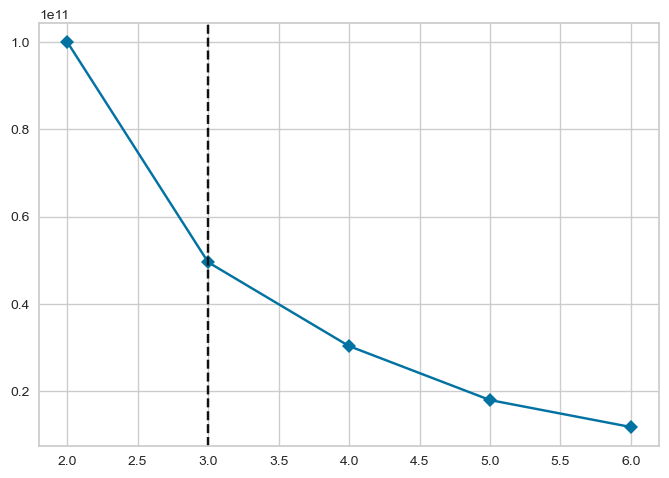

In [66]:
kmeans = KElbowVisualizer(KMeans(), k=n_clusters, timings=False)
kmeans.fit(X)
kmeans.show;

De acordo com a WCSS, o melhor número de clusters é 3. 

### 8.2 SS (*Silhouette Score*)

A métrica usada para verificar a *Separation* dos clusters vai ser a *Silhouette Score*

Para verificar essa métrica para diferentes números de clusters, também vou usar da função *KElbowVisualizer*, mas passando como parâmetro a métrica *silhouette*.

De acordo com essa métrica, o melhor valor para o número de clusters vai ser aquele que apresentar uma *Silhouette Score* mais próxima de 1. 

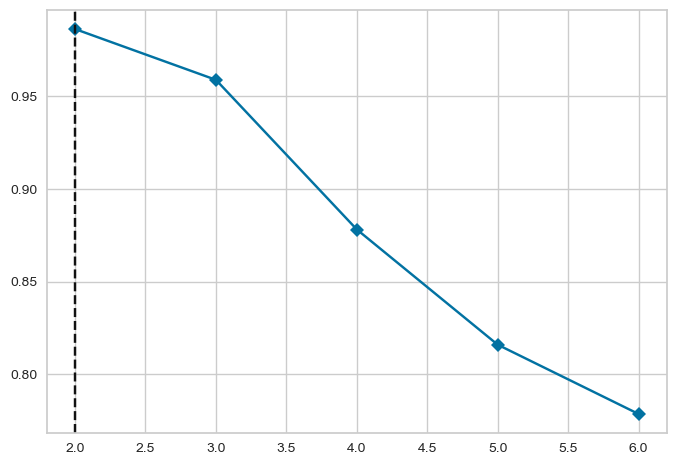

In [69]:
kmeans = KElbowVisualizer(KMeans(), k=n_clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show;

De acordo com a SS, o melhor número de clusters é 2, mas podemos ver que 3 clusters não apresentam uma performance muito pior. 

## 9. *Machine Learning*

## 10. *Cluster Analysis*

## 11. Modelo em Produção